In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import random
import pandas as pd
from collections import Counter
from itertools import chain

import torch
from torch.nn import functional as fnn
from contest01.train import init_model
from contest01.transforms import ToTensorV3, NUM_PTS

np.random.seed(1234)

import tqdm
from utils import ThousandLandmarksDataset, CROP_SIZE
from torch.utils.data import DataLoader
import albumentations as A
import seaborn as sns

In [3]:
train_path = './data/train/images/'
test_path = './data/test/images/'
train_img_names = [os.path.join(train_path, name) for name in os.listdir(train_path)]
test_img_names = [os.path.join(test_path, name) for name in os.listdir(test_path)]

In [4]:
train_transforms = A.Compose([
        A.SmallestMaxSize(128),
        A.CenterCrop(128, 128),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
        ToTensorV3(),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [5]:
with open('bad_images.bd') as fin:
    bad_img_names = fin.readlines()
    bad_img_names = [i.strip() for i in bad_img_names]
train_dataset = ThousandLandmarksDataset('data/train', train_transforms, split="val",
                                         bad_img_names=bad_img_names)
train_dataloader = DataLoader(train_dataset, batch_size=512, num_workers=4, pin_memory=True,
                              shuffle=True, drop_last=False)

100%|██████████| 64001/64001 [00:04<00:00, 13582.83it/s] 


In [35]:
# def count_hist(dataloader, batch_size=32):
#     bgr_stat = [[] for _ in range(3)]
#     for batch in tqdm.tqdm(dataloader):
#         imgs = batch['image']
#
#         red_values = [np.mean(img[:, :, 0].numpy()) for img in imgs]
#         green_values = [np.mean(img[:, :, 1].numpy()) for img in imgs]
#         blue_values = [np.mean(img[:, :, 2].numpy()) for img in imgs]
#
#         bgr_stat[0].extend(blue_values)
#         bgr_stat[1].extend(green_values)
#         bgr_stat[2].extend(red_values)
#     return bgr_stat

# train_rgb = count_hist(train_dataloader, batch_size=512)

In [6]:
device = torch.device('cuda')
model = init_model()
model.to(device)
model_path = 'runs/ablumentations_best.pth'
with open(model_path, "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)
loss_fn = fnn.mse_loss

Creating model...


In [7]:
val_loss = list()
per_point_loss = list()
per_coordinate_loss = list()
for i, batch in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc="validation...")):
    images = batch["image"].to(device)
    landmarks = batch["landmarks"].to(device)
    landmarks = landmarks.view(landmarks.shape[0], -1)

    with torch.no_grad():
        pred_landmarks = model(images)
    pp_loss = loss_fn(pred_landmarks, landmarks, reduction="none").to('cpu').numpy()
    val_loss.append(pp_loss.mean())
    per_point_loss.append(pp_loss.reshape(-1, 971, 2).mean(axis=-1).mean(axis=0))
    per_coordinate_loss.append(pp_loss.reshape(-1, 2).mean(axis=0))

validation...: 100%|██████████| 26/26 [02:13<00:00,  5.12s/it]


In [8]:
per_point_loss = np.array(per_point_loss)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2., 13.,  7.,  3.]),
 array([1.9020797, 2.0906477, 2.2792156, 2.4677837, 2.6563516, 2.8449194,
        3.0334876, 3.2220554, 3.4106233, 3.5991914, 3.7877593],
       dtype=float32),
 <a list of 10 Patch objects>)

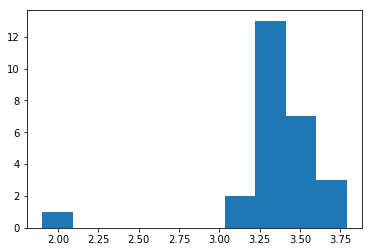

In [9]:
plt.hist(val_loss)

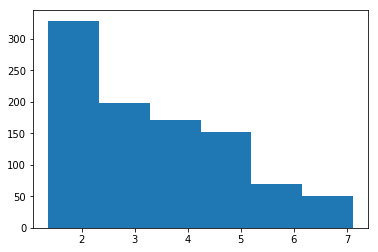

In [10]:
_, bins, _ = plt.hist(per_point_loss.mean(axis=0), bins=6)


In [12]:
groups_idx = [(left <= per_point_loss.mean(axis=0)) * (per_point_loss.mean(axis=0) <= right)
              for left, right in zip(bins[:-1], bins[1:])]

groups = [np.arange(NUM_PTS)[idx] for idx in groups_idx]

329


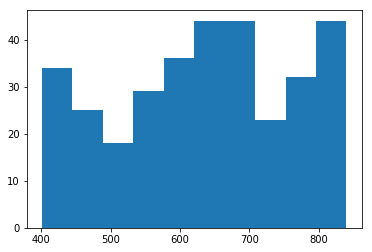

In [13]:
plt.hist(groups[0])
print(len(groups[0]))

51


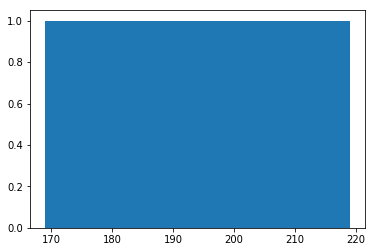

In [14]:
group = groups[-1]
plt.hist(group, bins=len(group))
print(len(group))

In [15]:
landmarks_pd = pd.read_csv('data/train/landmarks.csv', delimiter='\t')

In [16]:
palette = sns.color_palette()

In [37]:
group_palette = [(np.array(p) * 255).astype('int64') for p in palette[:len(groups)]]

In [26]:
idx_to_group = [None for _ in range(NUM_PTS)]
for i, group in enumerate(groups):
    for idx in group:
        idx_to_group[idx] = i
all(i is not None for i in idx_to_group)

True

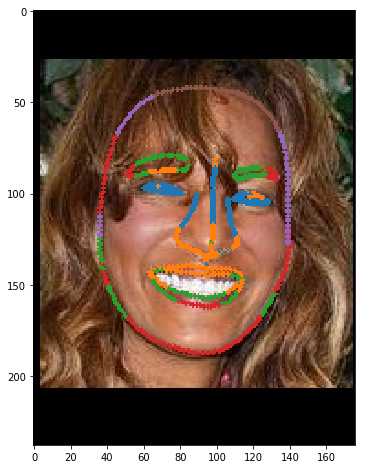

In [62]:
file = landmarks_pd.loc[np.random.randint(len(landmarks_pd)), 'file_name']
landmarks = landmarks_pd.loc[landmarks_pd.file_name == file].drop('file_name', axis=1).values
landmarks = landmarks.reshape(971, 2)
path = f'data/train/images/{file}'


# source image
src = cv2.imread(path)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# source image with landmarks
src_landm = src.copy()
for i, (x, y) in enumerate(landmarks):
    group = idx_to_group[i]
    cv2.circle(src_landm, (int(x), int(y)), 1, group_palette[group].tolist(), -1)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.imshow(src_landm)
plt.show()

In [60]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

'28e70684d6e2d6d75a6d3a973e4d4d93.jpg'